# 📊**Overview of dataset**

The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30000 training samples and 1900 testing samples. The total number of training samples is 120000 and testing 7600. In this training session we will load 10000 samples from the training file and 1000 testing samples.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

# **Import necessary library**

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import torch
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import warnings
import kagglehub
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset

# --- Download NLTK stopwords ---
try:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
except:
    print("Could not download stopwords. Proceeding without them.")
    stop_words = set()

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Error loading stopwords: <urlopen error Remote end closed
[nltk_data]     connection without response>


In [2]:
# GPU check
print("Current version of Torch: ", torch.__version__)
print("Is CUDA available: ", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current CUDA device: ", torch.cuda.current_device())
    print("CUDA device name: ", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

Current version of Torch:  2.8.0+cu126
Is CUDA available:  True
Current CUDA device:  0
CUDA device name:  NVIDIA GeForce GTX 1650


# **Loading datasets**
The first step in our project is to load the necessary data. We use the pandas library to read the train.csv and test.csv files into DataFrames. To ensure efficient processing and rapid prototyping, we work with a subset of the data: 10,000 samples for the training set and 1,000 randomly selected samples for the test set.

For each dataset, the Title and Description columns are concatenated into a single Text column. This combined text serves as the primary input feature for all our classification models. The target labels are defined by the Class Index, which corresponds to the four news categories: World, Sports, Business, and Sci/Tech.

In [3]:
# --- Download Data ---
path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")
print(f"Dataset downloaded to: {path}")
# --- Load Data ---
train_file_path = os.path.join(path, 'train.csv')
test_file_path = os.path.join(path, 'test.csv')
column_names = ['Class Index', 'Title', 'Description']

df_train = pd.read_csv(train_file_path, header=None, names=column_names, nrows=10000, skiprows=1)
df_test_full = pd.read_csv(test_file_path, header=None, names=column_names, skiprows=1)
df_test = df_test_full.sample(n=1000, random_state=42)

# --- Basic Preprocessing for EDA ---
df_train['Text'] = df_train['Title'] + " " + df_train['Description']
df_test['Text'] = df_test['Title'] + " " + df_test['Description']
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

100%|██████████| 11.4M/11.4M [00:04<00:00, 2.64MB/s]


Extracting files...
Dataset downloaded to: C:\Users\DELL\.cache\kagglehub\datasets\amananandrai\ag-news-classification-dataset\versions\2


## **Visualization**
Before building our models, we perform Exploratory Data Analysis (EDA) to gain insights into the dataset's characteristics. This helps us understand the data's structure and informs our preprocessing and modeling decisions.
### Class Distribution in Training Set
We start by visualizing the number of articles per class in both the training and test sets. This is a crucial step to check for class imbalance. Our analysis shows that the classes are nearly perfectly balanced, meaning each category has a similar number of samples. This is an ideal scenario, as it prevents the model from being biased towards a majority class.

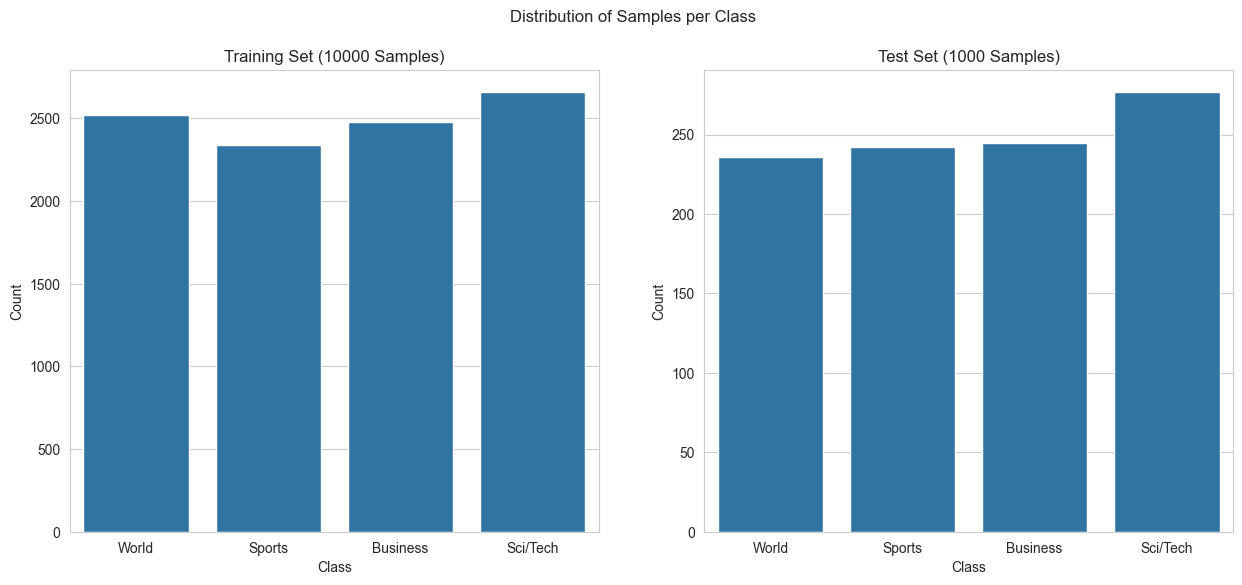

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Distribution of Samples per Class')

sns.countplot(ax=axes[0], x='Class Index', data=df_train)
axes[0].set_title('Training Set (10000 Samples)')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(class_names)

sns.countplot(ax=axes[1], x='Class Index', data=df_test)
axes[1].set_title('Test Set (1000 Samples)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_xticklabels(class_names)

plt.show()

### Text Length and Word Count Distribution
Next, we analyze the distribution of text lengths (in characters) and word counts per article. This helps us understand the typical length and verbosity of the news articles. The histograms reveal a right-skewed distribution, with most articles falling within a specific length range. This information is particularly valuable for the deep learning approach, as it helps us determine an appropriate max_length parameter for the BERT tokenizer, ensuring we capture most of the text without excessive padding or truncation.

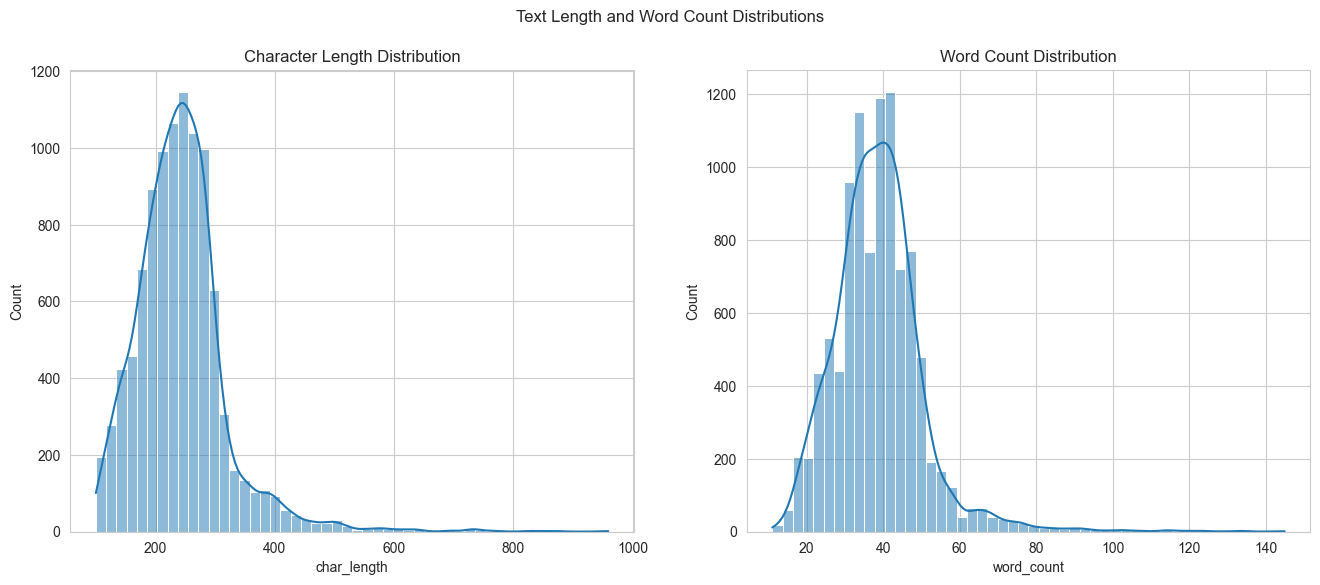

In [5]:
df_train['char_length'] = df_train['Text'].apply(len)
df_train['word_count'] = df_train['Text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Text Length and Word Count Distributions')

sns.histplot(ax=axes[0], data=df_train, x='char_length', bins=50, kde=True)
axes[0].set_title('Character Length Distribution')

sns.histplot(ax=axes[1], data=df_train, x='word_count', bins=50, kde=True)
axes[1].set_title('Word Count Distribution')

plt.show()

### Word Frequency
To understand the vocabulary of our corpus, we identify the most frequent words after performing basic text cleaning. This process involves converting text to lowercase, removing punctuation and common English "stop words" which carry little semantic meaning. The resulting bar chart of the top 20 words gives us a glimpse into the key terms that might be important for distinguishing between the different news categories.

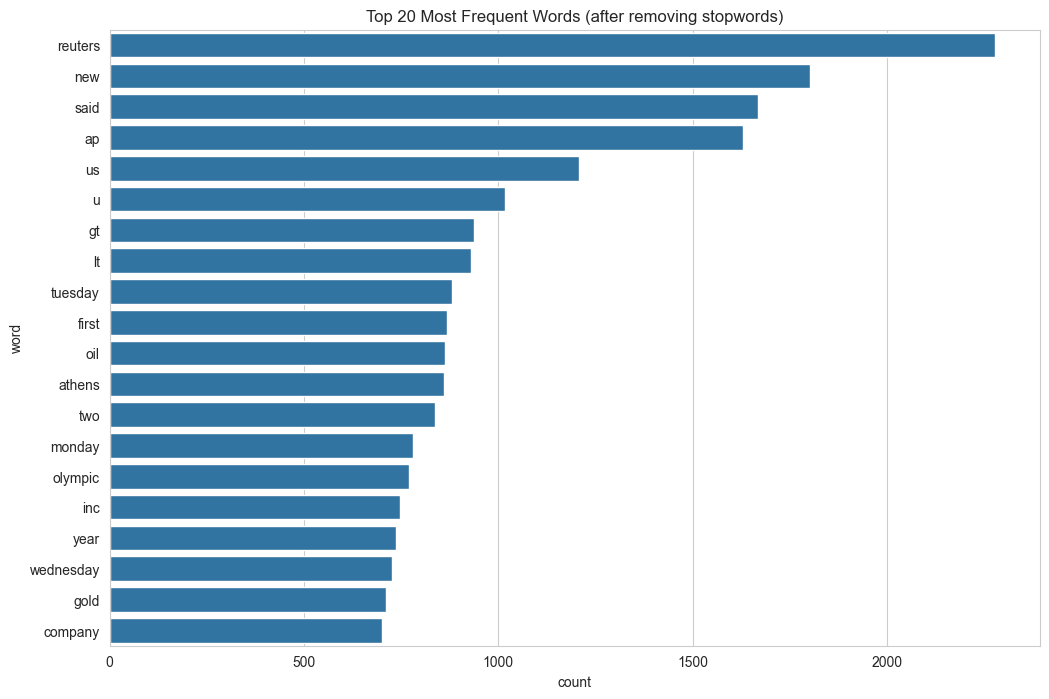

In [6]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

all_text = ' '.join(df_train['Text'].apply(clean_text))
words = [word for word in all_text.split() if word not in stop_words and not word.isdigit()]
word_counts = Counter(words)

common_words = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])

plt.figure(figsize=(12, 8))
sns.barplot(data=common_words, x='count', y='word')
plt.title('Top 20 Most Frequent Words (after removing stopwords)')
plt.show()

## **Feature Extraction (TF-IDF) and Storage**
In this step, we will convert the text data into numerical vectors using the TF-IDF technique. Then, the resulting feature matrices and their corresponding labels will be saved to .npy files.

In [ ]:
X_train_text = df_train['Text']
y_train_labels = (df_train['Class Index'].astype(int) - 1)
X_test_text = df_test['Text']
y_test_labels = (df_test['Class Index'].astype(int) - 1)

# --- Feature Extraction (TF-IDF) ---
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit on training data and transform both sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)
    
np.save('../features/train_features_tfidf.npy', X_train_tfidf.toarray())
np.save('../features/test_features_tfidf.npy', X_test_tfidf.toarray())
np.save('../features/train_labels.npy', y_train_labels)
np.save('../features/test_labels.npy', y_test_labels)

print("Saved TF-IDF features and labels to .npy files.")

Saved TF-IDF features and labels to .npy files.


: 

# **Build Pipeline - Model Training and Evaluation**
The core objective of this phase is to train and evaluate various classification models to determine which approach yields the best performance for this news categorization task.

## **All Traditional Model Approach**
Our traditional modeling pipeline is designed to be systematic and robust. Scikit-Learn's Pipeline and GridSearchCV is used to automate the process of feature extraction, model training, and hyperparameter tuning.

The raw text data is first converted into a numerical format that machine learning algorithms can understand. We use TfidfVectorizer, which transforms the text into a matrix of TF-IDF features. This method weighs words not only by their frequency in a document but also by how unique they are across the entire corpus, helping to highlight important keywords.

In [ ]:
# --- Load Features from .npy files ---
X_train = np.load('../features/train_features_tfidf.npy', allow_pickle=True)
y_train = np.load('../features/train_labels.npy', allow_pickle=True)
X_test = np.load('../features/test_features_tfidf.npy', allow_pickle=True)
y_test = np.load('../features/test_labels.npy', allow_pickle=True)

pipeline = Pipeline([
    ('clf', MultinomialNB())
])

parameters = [
    {
        'clf': [MultinomialNB()],
        'clf__alpha': [0.1, 0.5, 1.0],
    },
    {
        'clf': [LogisticRegression(random_state=42, max_iter=1000)],
        'clf__solver': ['liblinear', 'saga'],
        'clf__C': [0.1, 1, 10],
    },
    {
        'clf': [SVC(random_state=42)],
        'clf__kernel': ['linear', 'rbf'],
        'clf__C': [0.1, 1, 10],
    },
    {
        'clf': [RandomForestClassifier(random_state=42)],
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [None, 10, 20]
    }
]

grid_search = GridSearchCV(pipeline, parameters, cv=3, n_jobs=-1, verbose=2, scoring='accuracy', return_train_score=True)
print("Starting GridSearchCV to find the best traditional model...")
grid_search.fit(X_train, y_train)

Starting GridSearchCV to find the best traditional model...
Fitting 3 folds for each of 21 candidates, totalling 63 fits


## **Deep Learning Approach (Fine-tuning BERT)**
For our modern approach, we leverage a powerful pre-trained language model called BERT (Bidirectional Encoder Representations from Transformers). Unlike traditional methods that treat text as a bag of words, BERT is designed to understand the context and semantic relationships between words in a sentence using BertTokenizer.

Fine-Tuning: We then use a pre-trained bert-base-uncased model and add a classification layer on top, configured for our four news categories. The core of this approach is fine-tuning, where we continue training the entire model on our specific news dataset. This process adjusts BERT's internal weights to specialize its general language understanding for our classification task. The model is trained for a few epochs using the AdamW optimizer, which is well-suited for transformer models.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(class_names))
model.to(device)

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = NewsDataset(X_train_text, y_train, tokenizer, 128)
test_dataset = NewsDataset(X_test_text, y_test, tokenizer, 128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 2 # EPOCHS = 2
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

print("\nStarting BERT fine-tuning...")
for epoch in range(2):
    print(f'\nEpoch {epoch + 1}/2')
    model.train()
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

print("\nEvaluating BERT model on the test set...")
model.eval()
all_preds_bert = []
all_labels_bert = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds_bert.extend(preds.cpu().numpy())
        all_labels_bert.extend(labels.cpu().numpy())

report_dict_bert = classification_report(all_labels_bert, all_preds_bert, target_names=class_names, output_dict=True)

## **Comprehensive Performance Comparison**
The summary table includes the following key information for each model:

**Model**: The name of the algorithm.

**Parameters**: The specific hyperparameters used for that configuration.

**Validation Accuracy**: The cross-validation accuracy score from GridSearchCV (not applicable to BERT).

**Test Accuracy**: The final accuracy score on the held-out test set. This is the primary metric for comparison.

**Test F1-Score (Macro)**: The macro-averaged F1-score on the test set, which provides a balanced measure of precision and recall across all classes.

In [ ]:
results_df = pd.DataFrame(grid_search.cv_results_)
comparison_list = []

print("Calculating test set results for each traditional model configuration...")
for i, row in tqdm(results_df.iterrows(), total=len(results_df)):
    params = row['params']
    model_name = params['clf'].__class__.__name__

    # Since TF-IDF is not in the pipeline, we directly use the loaded test features
    # We need to re-fit a standalone model instance with the best params to predict
    model_instance = params['clf']
    model_instance.set_params(**{k.replace('clf__', ''): v for k, v in params.items() if k != 'clf'})
    model_instance.fit(X_train, y_train)
    y_pred = model_instance.predict(X_test)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    comparison_list.append({
        'Model': model_name,
        'Parameters': str({k.replace("clf__", ""): v for k, v in params.items() if k != 'clf'}),
        'Validation Accuracy': row['mean_test_score'],
        'Test Accuracy': report_dict['accuracy'],
        'Test F1-Score (Macro)': report_dict['macro avg']['f1-score']
    })

comparison_list.append({
    'Model': 'BERT (Fine-tuned)',
    'Parameters': MODEL_NAME,
    'Validation Accuracy': None,
    'Test Accuracy': report_dict_bert['accuracy'],
    'Test F1-Score (Macro)': report_dict_bert['macro avg']['f1-score']
})

final_comparison_df = pd.DataFrame(comparison_list).round(4)
final_comparison_df = final_comparison_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

print("\n" + "="*90)
print("                         COMPREHENSIVE PERFORMANCE COMPARISON TABLE")
print("="*90)
display(final_comparison_df)

In [ ]:
print("\n" + "="*80)
print("                  DETAILED REPORT FOR THE BEST PERFORMING MODEL")
print("="*80)

best_model_info = final_comparison_df.iloc[0]
best_model_name = best_model_info['Model']

print(f"The best performing model is: {best_model_name} with parameters {best_model_info['Parameters']}\n")

if 'BERT' in best_model_name:
    print(classification_report(all_labels_bert, all_preds_bert, target_names=class_names))
else:
    best_traditional_model = grid_search.best_estimator_
    y_pred_best_traditional = best_traditional_model.predict(X_test)
    print(classification_report(y_test, y_pred_best_traditional, target_names=class_names))


# **Project Conclusion**
This project aimed to classify news articles into four categories and compare the efficacy of traditional machine learning techniques against a modern deep learning approach. Based on the comprehensive evaluation, we can have some conclusions:

**High Performance of Deep Learning**: The fine-tuned BERT model emerged as the clear winner, achieving the highest Test Accuracy of 91.3% and a macro F1-score of 91.33%. This significantly outperforms all traditional models tested.

**Strong Performance of Traditional Baselines**: Among the traditional methods, the Support Vector Classifier (SVC) with an RBF kernel was the top performer, achieving a respectable Test Accuracy of 87.1%. Other models like RandomForestClassifier and LogisticRegression also delivered solid results, demonstrating that a well-tuned traditional pipeline with TF-IDF features serves as a strong and effective baseline for text classification.

**Performance vs. Complexity Trade-off**: While BERT's performance is superior, it comes with significantly higher computational complexity. Training the BERT model requires a GPU and takes considerably more time compared to the traditional models, which can be trained quickly on a standard CPU.